# Monsoon Index Based on Wang and Ding 2006
### https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2005GL025347

In [1]:
# Import Packages
import os
import pandas as pd
import numpy as np
import Ngl
import xarray as xr
import netCDF4 as nc
import time
import pandas as pd

#Plotting packages
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs
import cartopy.util as cutil
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LongitudeFormatter, LatitudeFormatter
import geocat as gc
import geocat.viz as gv
import cmaps

In [20]:
# Load post-processed seasonal precipitation

DIR = '/glade/work/pacosta/tools/scripts/python_bin/MioMIP/Converted_data/final/season/'

CASE0 = xr.open_dataset(DIR+"MMIO280-1deg-Seasonal-Precip-Normalized.nc") #0
CASE1 = xr.open_dataset(DIR+"MMIO400-1deg-Seasonal-Precip-Normalized.nc") #1
CASE2 = xr.open_dataset(DIR+"MMIO560-1deg-Seasonal-Precip-Normalized.nc") #2
CASE3 = xr.open_dataset(DIR+"MMIO850-1deg-Seasonal-Precip-Normalized.nc") #3

lat = CASE0.lat[:]
lon = CASE0.lon[:]

prMASK0 =  (CASE0.prMASK[:,:])
prMASK1 =  (CASE1.prMASK[:,:])
prMASK2 =  (CASE2.prMASK[:,:])
prMASK3 =  (CASE3.prMASK[:,:])


prMASKset = xr.Dataset({'prMASK0': xr.DataArray(prMASK0[:,:],dims = ['lat','lon'],coords = {'lat': lat, 'lon': lon},),
                         'prMASK1': xr.DataArray(prMASK1[:,:],dims = ['lat','lon'],coords = {'lat': lat, 'lon': lon},),
                         'prMASK2': xr.DataArray(prMASK2[:,:],dims = ['lat','lon'],coords = {'lat': lat, 'lon': lon},),
                         'prMASK3': xr.DataArray(prMASK3[:,:],dims = ['lat','lon'],coords = {'lat': lat, 'lon': lon},),
                        },
    attrs = {'Global_attr': 'Created by PA 2023'}
    )
prMASKary = prMaskset.to_array()  


prNorm0 =  (CASE0.prNorm[:,:])
prNorm1 =  (CASE1.prNorm[:,:])
prNorm2 =  (CASE2.prNorm[:,:])
prNorm3 =  (CASE3.prNorm[:,:])

prNormset = xr.Dataset({'prNorm0': xr.DataArray(prNorm0[:,:],dims = ['lat','lon'],coords = {'lat': lat, 'lon': lon},),
                         'prNorm1': xr.DataArray(prNorm1[:,:],dims = ['lat','lon'],coords = {'lat': lat, 'lon': lon},),
                         'prNorm2': xr.DataArray(prNorm2[:,:],dims = ['lat','lon'],coords = {'lat': lat, 'lon': lon},),
                         'prNorm3': xr.DataArray(prNorm3[:,:],dims = ['lat','lon'],coords = {'lat': lat, 'lon': lon},),
                        },
    attrs = {'Global_attr': 'Created by PA 2023'}
    )
prNormary = prNormset.to_array()

In [3]:
DIRPI = '/glade/work/pacosta/tools/scripts/python_bin/MioMIP/Converted_data/final/'
CASEPI = xr.open_dataset(DIRPI+"PI-1deg-ANN-PE.nc") #1

sec2day = (60.*60.*24.)
m2mm = 1000.

latspi = CASEPI.lat[:]
lonspi = CASEPI.lon[:]

prAPI =  (CASEPI.pr)*sec2day #mm/day 

In [4]:
#Read in updated Herold boundary conditions
MioMIPDIR = "/glade/work/pacosta/tools/scripts/python_bin/MioMIP/Scripts/MioMIP1/"
filename='miocene_topo_pollard_antscape_dolan_0.5x0.5.nc'
Herold_updated=xr.open_dataset(MioMIPDIR+filename,decode_times=False)

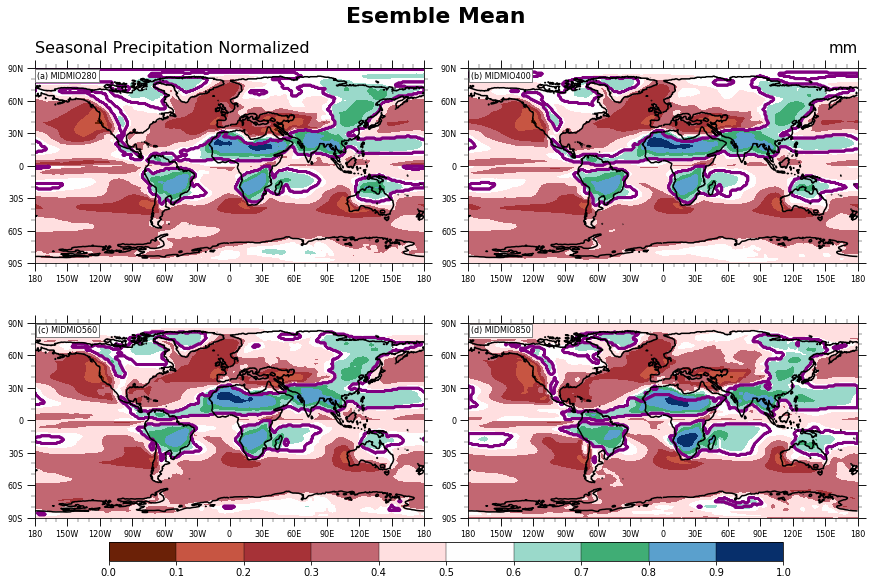

In [21]:
# Plotting Routine
def add_axes(fig, grid_space):
    ax = fig.add_subplot(grid_space, projection=ccrs.PlateCarree())

    # Usa geocat.viz.util convenience function to set axes parameters
    gv.set_axes_limits_and_ticks(ax,
                                     ylim=(-90, 90),
                                     xlim=(-180, 180),
                                     xticks=np.arange(-180, 181, 30),
                                     yticks=np.arange(-90, 91, 30))

    # Use geocat.viz.util convenience function to add minor and major tick lines
    gv.add_major_minor_ticks(ax, labelsize=8)

    # Use geocat.viz.util convenience function to make plots look like NCL
    # plots by using latitude, longitude tick labels
    gv.add_lat_lon_ticklabels(ax)

    # Remove the degree symbol from tick labels
    ax.yaxis.set_major_formatter(LatitudeFormatter(degree_symbol=''))
    ax.xaxis.set_major_formatter(LongitudeFormatter(degree_symbol=''))

    return ax

# Generate figure (set its size (width, height) in inches)
fig = plt.figure(figsize=(12, 11.2), constrained_layout=True)

# Create gridspec to hold six subplots
grid = fig.add_gridspec(ncols=2, nrows=3)

# Add the axes
ax1 = add_axes(fig, grid[0, 0])
ax2 = add_axes(fig, grid[0, 1])
ax3 = add_axes(fig, grid[1, 0])
ax4 = add_axes(fig, grid[1, 1])

# misc
CNlevels = np.arange(0.,1.1,.1) #Set contour levels
#cmap = plt.get_cmap('precip_11lev')# Colormap
newcmp = cmaps.precip4_diff_19lev # Colormap
name = ["(a) MIDMIO280","(b) MIDMIO400","(c) MIDMIO560","(d) MIDMIO850"] 
norm = mcolors.BoundaryNorm(boundaries=CNlevels, ncolors=20)
cyclic_data0, cyclic_lon0 = cutil.add_cyclic_point(prMASKary, coord=prMASKary.lon)
cyclic_data1, cyclic_lon1 = cutil.add_cyclic_point(prNormary, coord=prNormary.lon)

for i, axes in enumerate([ax1, ax2, ax3, ax4]):
    # Contourf plot data
    contour = axes.contourf(cyclic_lon1,
                            prNormary.lat,
                            cyclic_data1[i],
                            norm=norm,
                            cmap=newcmp,
                            levels=CNlevels)
    axes.contour(cyclic_lon0,
                 prMASKary.lat,
                 cyclic_data0[i],
                 colors='purple',
                 linewidths=2)
    axes.contour(Herold_updated.topo.lon,Herold_updated.topo.lat,Herold_updated.topo, levels=[0], colors='k', linestyles='-')
    # Add lower text box
    axes.text(0.16,
              0.95,
              name[i],
              horizontalalignment='right',
              transform=axes.transAxes,
              fontsize=8,
              bbox=dict(boxstyle='square, pad=0.25',
                        facecolor='white',
                        edgecolor='gray'),
              zorder=5)

# Set colorbounds of norm
colorbounds = CNlevels
# Use cmap to create a norm and mappable for colorbar to be correctly plotted
#norm = mcolors.BoundaryNorm(colorbounds, newcmp.N)
#mappable = cm.ScalarMappable(norm=norm, cmap=newcmp)

# Add colorbar for all six plots
fig.colorbar(contour,
             ax=[ax1, ax2, ax3, ax4],
            ticks=colorbounds,
             drawedges=True,
             orientation='horizontal',
             shrink=0.82,
             pad=0.01,
             aspect=35,
             extendfrac='auto',
             extendrect=True)

#cbar = plt.colorbar(contour, orientation='horizontal', shrink=0.5)
#cbar.ax.tick_params(labelsize=7)
#cbar.set_ticks(np.arange(0, 3000, 100))
    
    
# Add figure titles
fig.suptitle("Esemble Mean", fontsize=22, fontweight='bold')
ax1.set_title("Seasonal Precipitation Normalized", loc="left", fontsize=16, y=1.05)
ax2.set_title("mm", loc="right", fontsize=15, y=1.05)

# Show plot
plt.show()


## Generate comparison plots

In [19]:
# GPCP calc
DIROBS = '/glade/work/pacosta/tools/scripts/python_bin/MioMIP/Converted_data/final/' 
filename = "GPCP-1deg-monthlymean.nc"
GPCPcase = xr.open_dataset(DIROBS+filename)
GPCP =  (GPCPcase.pr[:,:,:])  #mm/year 

GPCPAS = xr.concat([GPCP[0,:,:],GPCP[1,:,:],GPCP[2,:,:],GPCP[10,:,:],GPCP[11,:,:]],dim="time")
GPCPASm = GPCPAS.mean(dim='time', keep_attrs = True)
GPCPBS = xr.concat([GPCP[4,:,:],GPCP[5,:,:],GPCP[6,:,:],GPCP[7,:,:],GPCP[8,:,:]],dim="time")
GPCPBSm = GPCPBS.mean(dim='time', keep_attrs = True)

#Create monsoon zones

# Sum months

prBSSUMg = GPCPBS.sum(dim='time')
prASSUMg = GPCPAS.sum(dim='time')
prANSUMg = GPCP.sum(dim='time')

#normalized summer values by annual values
prBSNormg = prBSSUMg/prANSUMg
prASNormg = prASSUMg/prANSUMg


#Criteria set for 60% 

prBSMASKg = xr.where((prBSNormg > .55) & (prBSSUMg>3.) ,1,0) #.55
prASMASKg = xr.where((prASNormg > .55) & (prASSUMg>3.) ,1,0)

#Create mirror image of Hemisphere using where function
prNorm0g = xr.where(prBSNormg.lat<0,prASNormg,prBSNormg)
prMASK1g = xr.where(prBSMASKg.lat<0,prASMASKg,prBSMASKg)

#Remove polar monsoons
prMASK0g = xr.where((prMASK1g.lat>60)|(prMASK1g.lat<-65), 0,prMASK1g)

In [22]:
DIRs = "/glade/work/pacosta/tools/scripts/python_bin/MioMIP/Converted_data/final/season/"

MASKPI = xr.open_dataset(DIRs+"PI-1deg-Seasonal-Precip-Normalized.nc")

MASK280 = xr.open_dataset(DIRs+"MMIO280-1deg-Seasonal-Precip-Normalized.nc") #0
MASK400 = xr.open_dataset(DIRs+"MMIO400-1deg-Seasonal-Precip-Normalized.nc") #1
MASK560 = xr.open_dataset(DIRs+"MMIO560-1deg-Seasonal-Precip-Normalized.nc") #2
MASK850 = xr.open_dataset(DIRs+"MMIO850-1deg-Seasonal-Precip-Normalized.nc") #3


#prMASK0 = xr.where((prMASK1.lat>60), 0,prMASK1 )

prMASKPI =  MASKPI.prMASK
prMASK280 =  MASK280.prMASK
prMASK400 =  MASK400.prMASK
prMASK560 =  MASK560.prMASK
prMASK850 =  MASK850.prMASK
prMASKGPCP = prMASK0g

prMASK280z = xr.where((prMASK280.lat>60)|(prMASK280.lat<-65), 0,prMASK280 )
prMASK400z = xr.where((prMASK400.lat>60)|(prMASK280.lat<-65), 0,prMASK400 )
prMASK560z = xr.where((prMASK560.lat>60)|(prMASK280.lat<-65), 0,prMASK560 )
prMASK850z = xr.where((prMASK850.lat>60)|(prMASK280.lat<-65), 0,prMASK850 )

prMaskset = xr.Dataset({'prMASKGPCP': xr.DataArray(prMASKGPCP[:,:],dims = ['lat','lon'],coords = {'lat': lat, 'lon': lon},),
                         'prMASKPI': xr.DataArray(prMASKPI[:,:],dims = ['lat','lon'],coords = {'lat': lat, 'lon': lon},),
                         'prMASK280': xr.DataArray(prMASK280z[:,:],dims = ['lat','lon'],coords = {'lat': lat, 'lon': lon},),
                         'prMASK400': xr.DataArray(prMASK400z[:,:],dims = ['lat','lon'],coords = {'lat': lat, 'lon': lon},),
                         'prMASK560': xr.DataArray(prMASK560z[:,:],dims = ['lat','lon'],coords = {'lat': lat, 'lon': lon},),
                         'prMASK850': xr.DataArray(prMASK850z[:,:],dims = ['lat','lon'],coords = {'lat': lat, 'lon': lon},),
                        },
    attrs = {'Global_attr': 'Created by PA 2023'}
    )
prMaskary = prMaskset.to_array() 


In [23]:
# Seperate monsoon regions

#monsoon region = 1 otherwise fillvalue
Monsoonmask = xr.where(prMaskary>.90,prMaskary,np.nan)
#plt.contourf(Monsoonmask[1,:,:])

#North American region
NAMmask = Monsoonmask
NAMmask = xr.where((prMaskary>.90) & (prMaskary.lat>0) & (prMaskary.lat<60) & (prMaskary.lon>240) & (prMaskary.lon<280),1,np.nan)
#plt.contourf(NAMmask[0,:,:])

#South American region
SAMmask = Monsoonmask
SAMmask = xr.where((prMaskary>.90) & (prMaskary.lat<0) & (prMaskary.lat>-60) & (prMaskary.lon>270) & (prMaskary.lon<350),1,np.nan)


#North African
NAFMmask = Monsoonmask
NAFMmask = xr.where((prMaskary>.90) & (prMaskary.lat>0) & (prMaskary.lat<35) & (prMaskary.lon>340) | 
                    (prMaskary>.90) & (prMaskary.lat>0) & (prMaskary.lat<35) &(prMaskary.lon<58),
                    1,np.nan)

#South African
SAFMmask = Monsoonmask
SAFMmask = xr.where((prMaskary>.90) & (prMaskary.lat<0) & (prMaskary.lat>-60) & (prMaskary.lon<45),1,np.nan)

#Indo-Asian
IAMmask = Monsoonmask
IAMmask = xr.where((prMaskary>.90) & (prMaskary.lat>0) & (prMaskary.lat<=35) & (prMaskary.lon>50) & (prMaskary.lon<120),1,np.nan)

#East Asian
EAMmask = Monsoonmask
EAMmask = xr.where((prMaskary>.90) & (prMaskary.lat>=35) & (prMaskary.lat<60) & (prMaskary.lon>50) & (prMaskary.lon<160),1,np.nan)


#Australian 
AMmask = Monsoonmask
AMmask = xr.where((prMaskary>.90) & (prMaskary.lat<0) & (prMaskary.lat>-60) & (prMaskary.lon<170) & (prMaskary.lon>100),1,np.nan)

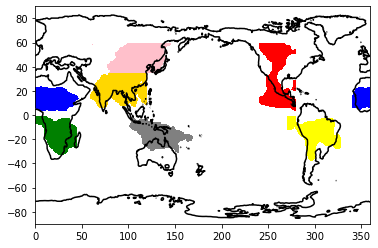

In [29]:
#Visualize individual monsoon regions
plotnum =0 #GPCP
plt.contour(Herold_updated.topo.lon,Herold_updated.topo.lat,Herold_updated.topo, levels=[0], colors='k', linestyles='-')
plt.contourf(NAMmask.lon,NAMmask.lat,NAMmask[plotnum,:,:],colors='Red')
plt.contourf(NAMmask.lon,NAMmask.lat,SAMmask[plotnum,:,:],colors='Yellow')
plt.contourf(NAMmask.lon,NAMmask.lat,SAFMmask[plotnum,:,:],colors='Green')
plt.contourf(NAMmask.lon,NAMmask.lat,NAFMmask[plotnum,:,:],colors='Blue')
plt.contourf(NAMmask.lon,NAMmask.lat,IAMmask[plotnum,:,:],colors='Gold')
plt.contourf(NAMmask.lon,NAMmask.lat,EAMmask[plotnum,:,:],colors='Pink')
plt.contourf(NAMmask.lon,NAMmask.lat,AMmask[plotnum,:,:],colors='grey')

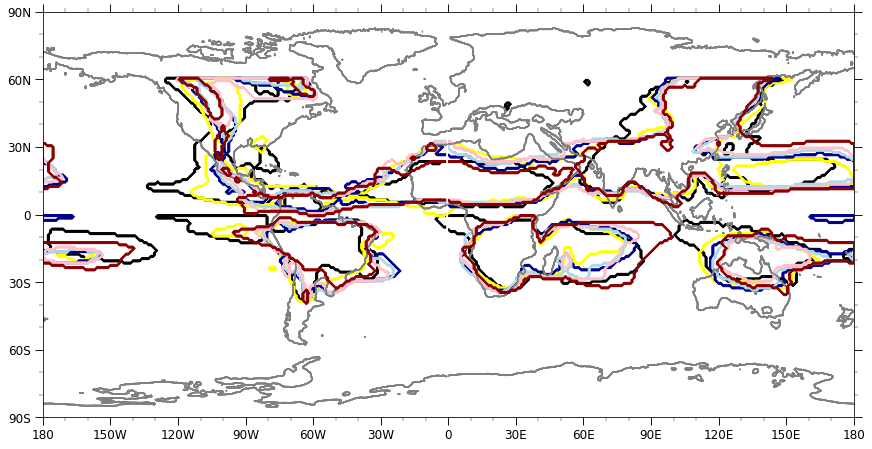

In [24]:
#plot all model cases
def add_axes(fig, grid_space):
    ax = fig.add_subplot(grid_space, projection=ccrs.PlateCarree())

    # Usa geocat.viz.util convenience function to set axes parameters
    gv.set_axes_limits_and_ticks(ax,
                                     ylim=(-90, 90),
                                     xlim=(-180, 180),
                                     xticks=np.arange(-180, 181, 30),
                                     yticks=np.arange(-90, 91, 30))

    # Use geocat.viz.util convenience function to add minor and major tick lines
    gv.add_major_minor_ticks(ax, labelsize=12)

    # Use geocat.viz.util convenience function to make plots look like NCL
    # plots by using latitude, longitude tick labels
    gv.add_lat_lon_ticklabels(ax)

    # Remove the degree symbol from tick labels
    ax.yaxis.set_major_formatter(LatitudeFormatter(degree_symbol=''))
    ax.xaxis.set_major_formatter(LongitudeFormatter(degree_symbol=''))

    return ax

# Generate figure (set its size (width, height) in inches)
fig = plt.figure(figsize=(12, 11.2), constrained_layout=True)

# Create gridspec to hold six subplots
grid = fig.add_gridspec(ncols=1, nrows=1)

# Add the axes
ax1 = add_axes(fig, grid[0, 0])

colorrotation = ["black","yellow","darkblue","lightblue","pink","darkred"]

for i in range(0, len(prMaskary)):
    plt.contour(Herold_updated.topo.lon,Herold_updated.topo.lat,Herold_updated.topo, levels=[0], colors="grey", linestyles='-')
    plt.contour(Monsoonmask.lon,Monsoonmask.lat,prMaskary[i,:,:],colors=colorrotation[i],linewidths=1)
    
plt.show()

## Create Annual Cycle Plots

In [48]:
DIR = '/glade/work/pacosta/tools/scripts/python_bin/MioMIP/Converted_data/final/'

CASEPI = xr.open_dataset(DIR+"PI-1deg-ANN-PE_wTime.nc")
CASE280 = xr.open_dataset(DIR+"MMIO280-1deg-ANN-PE_wTime.nc") #0
CASE400 = xr.open_dataset(DIR+"MMIO400-1deg-ANN-PE_wTime.nc") #1
CASE560 = xr.open_dataset(DIR+"MMIO560-1deg-ANN-PE_wTime.nc") #2
CASE850 = xr.open_dataset(DIR+"MMIO850-1deg-ANN-PE_wTime.nc") #3

In [49]:
time = CASEPI.time

prPI =  (CASEPI.pr[:,:,:,:])
pr280 =  (CASE280.pr[:,:,:,:])
pr400 =  (CASE400.pr[:,:,:,:])
pr560 =  (CASE560.pr[:,:,:,:])
pr850 =  (CASE850.pr[:,:,:,:])

prGPCP = GPCP
prMMMPI = prPI.mean(dim='exp', keep_attrs = True)
prMMM280 = pr280.mean(dim='exp', keep_attrs = True)
prMMM400 = pr400.mean(dim='exp', keep_attrs = True)
prMMM560 = pr560.mean(dim='exp', keep_attrs = True)
prMMM850 = pr850.mean(dim='exp', keep_attrs = True)

prMMMset = xr.Dataset({'prMASKGPCP': xr.DataArray(prGPCP[:,:,:],dims = ['time','lat','lon'],coords = {'time': time,'lat': lat, 'lon': lon},),
                         'prMASKPI': xr.DataArray(prMMMPI[:,:,:],dims = ['time','lat','lon'],coords = {'time': time,'lat': lat, 'lon': lon},),
                         'prMASK280': xr.DataArray(prMMM280[:,:,:],dims = ['time','lat','lon'],coords = {'time': time,'lat': lat, 'lon': lon},),
                         'prMASK400': xr.DataArray(prMMM400[:,:,:],dims = ['time','lat','lon'],coords = {'time': time,'lat': lat, 'lon': lon},),
                         'prMASK560': xr.DataArray(prMMM560[:,:,:],dims = ['time','lat','lon'],coords = {'time': time,'lat': lat, 'lon': lon},),
                         'prMASK850': xr.DataArray(prMMM850[:,:,:],dims = ['time','lat','lon'],coords = {'time': time,'lat': lat, 'lon': lon},),
                        },
    attrs = {'Global_attr': 'Created by PA 2023'}
    )
prMMMary = prMMMset.to_array() 

prMMMary0 = prMMMary.rename({'variable': 'exp'})

In [50]:
#Add time dimension

NAMmaskn = NAMmask.rename({'variable': 'exp'})
NAMmaskt = NAMmaskn.expand_dims({'time':prMMMary.time}).astype(np.float32)
NAMmaskt0 = NAMmaskt.transpose("exp","time","lat","lon")
NAMmaskt0

SAMmaskn = SAMmask.rename({'variable': 'exp'})
SAMmaskt = SAMmaskn.expand_dims({'time':prMMMary.time}).astype(np.float32)
SAMmaskt0 = SAMmaskt.transpose("exp","time","lat","lon")
SAMmaskt0

NAFMmaskn = NAFMmask.rename({'variable': 'exp'})
NAFMmaskt = NAFMmaskn.expand_dims({'time':prMMMary.time}).astype(np.float32)
NAFMmaskt0 = NAFMmaskt.transpose("exp","time","lat","lon")
NAFMmaskt0

SAFMmaskn =SAFMmask.rename({'variable': 'exp'})
SAFMmaskt = SAFMmaskn.expand_dims({'time':prMMMary.time}).astype(np.float32)
SAFMmaskt0 = SAFMmaskt.transpose("exp","time","lat","lon")
SAFMmaskt0

IAMmaskn = IAMmask.rename({'variable': 'exp'})
IAMmaskt = IAMmaskn.expand_dims({'time':prMMMary.time}).astype(np.float32)
IAMmaskt0 = IAMmaskt.transpose("exp","time","lat","lon")
IAMmaskt0

EAMmaskn = EAMmask.rename({'variable': 'exp'})
EAMmaskt = EAMmaskn.expand_dims({'time':prMMMary.time}).astype(np.float32)
EAMmaskt0 = EAMmaskt.transpose("exp","time","lat","lon")
EAMmaskt0

AMmaskn = AMmask.rename({'variable': 'exp'})
AMmaskt = AMmaskn.expand_dims({'time':prMMMary.time}).astype(np.float32)
AMmaskt0 = AMmaskt.transpose("exp","time","lat","lon")

In [51]:
#Calculate annual progression of precipitation according to monsoon regions

#NAM 
NAMAP = prMMMary0
NAMAP = xr.where(NAMmaskt0>=1, prMMMary0, np.nan)
NAMAP0 = NAMAP.mean(dim='lon', keep_attrs = True)
NAMAP1 = NAMAP0.mean(dim='lat', keep_attrs = True)
NAMAP2 = NAMAP1.transpose("time","exp")

#SAM 
SAMAP = prMMMary0
SAMAP = xr.where(SAMmaskt0>=1, prMMMary0, np.nan)
SAMAP0 = SAMAP.mean(dim='lon', keep_attrs = True)
SAMAP1 = SAMAP0.mean(dim='lat', keep_attrs = True)
SAMAP2 = SAMAP1.transpose("time","exp")

#NAFM 
NAFMAP = prMMMary0
NAFMAP = xr.where(NAFMmaskt0>=1, prMMMary0, np.nan)
NAFMAP0 = NAFMAP.mean(dim='lon', keep_attrs = True)
NAFMAP1 = NAFMAP0.mean(dim='lat', keep_attrs = True)
NAFMAP2 = NAFMAP1.transpose("time","exp")

#SAFM 
SAFMAP = prMMMary0
SAFMAP = xr.where(SAFMmaskt0>=1, prMMMary0, np.nan)
SAFMAP0 = SAFMAP.mean(dim='lon', keep_attrs = True)
SAFMAP1 = SAFMAP0.mean(dim='lat', keep_attrs = True)
SAFMAP2 = SAFMAP1.transpose("time","exp")

#IAM 
IAMAP = prMMMary0
IAMAP = xr.where(IAMmaskt0>=1, prMMMary0, np.nan)
IAMAP0 = IAMAP.mean(dim='lon', keep_attrs = True)
IAMAP1 = IAMAP0.mean(dim='lat', keep_attrs = True)
IAMAP2 = IAMAP1.transpose("time","exp")

#EAM 
EAMAP = prMMMary0
EAMAP = xr.where(EAMmaskt0>=1, prMMMary0, np.nan)
EAMAP0 = EAMAP.mean(dim='lon', keep_attrs = True)
EAMAP1 = EAMAP0.mean(dim='lat', keep_attrs = True)
EAMAP2 = EAMAP1.transpose("time","exp")

#AM 
AMAP = prMMMary0
AMAP = xr.where(AMmaskt0>=1, prMMMary0, np.nan)
AMAP0 = AMAP.mean(dim='lon', keep_attrs = True)
AMAP1 = AMAP0.mean(dim='lat', keep_attrs = True)
AMAP2 = AMAP1.transpose("time","exp")

GLMAP = prMMMary0
GLMAP = xr.where((AMmaskt0>=1) | (EAMmaskt0>=1) | (IAMmaskt0>=1) |
                 (NAMmaskt0>=1) | (SAMmaskt0>=1) | 
                 (NAFMmaskt0>=1) | (SAFMmaskt0>=1)
                 , prMMMary0, np.nan)
GLMAP0 = GLMAP.mean(dim='lon', keep_attrs = True)
GLMAP1 = GLMAP0.mean(dim='lat', keep_attrs = True)
GLMAP2 = GLMAP1.transpose("time","exp")

exp = GLMAP2.exp

regionset = xr.Dataset({'NAMAP2': xr.DataArray(NAMAP2[:,:],dims = ['time','exp'],coords = {'time': time, 'exp': exp},),
                         'SAMAP2': xr.DataArray(SAMAP2[:,:],dims = ['time','exp'],coords = {'time': time, 'exp': exp},),
                         'NAFMAP2': xr.DataArray(NAFMAP2[:,:],dims = ['time','exp'],coords = {'time': time, 'exp': exp},),
                         'SAFMAP2': xr.DataArray(SAFMAP2[:,:],dims = ['time','exp'],coords = {'time': time, 'exp': exp},),
                         'IAMAP2': xr.DataArray(IAMAP2[:,:],dims = ['time','exp'],coords = {'time': time, 'exp': exp},),
                         'EAMAP2': xr.DataArray(EAMAP2[:,:],dims = ['time','exp'],coords = {'time': time, 'exp': exp},),
                         'AMAP2': xr.DataArray(AMAP2[:,:],dims = ['time','exp'],coords = {'time': time, 'exp': exp},),
                         'GLMAP2': xr.DataArray(GLMAP2[:,:],dims = ['time','exp'],coords = {'time': time, 'exp': exp},),
                        },
    attrs = {'Global_attr': 'Created by PA 2023'}
    )
regionary = regionset.to_array() 

regionary1 = regionary.rename({'variable': 'regions'})
regionary2 = regionary1.transpose("time","regions","exp")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 2000x1200 with 0 Axes>

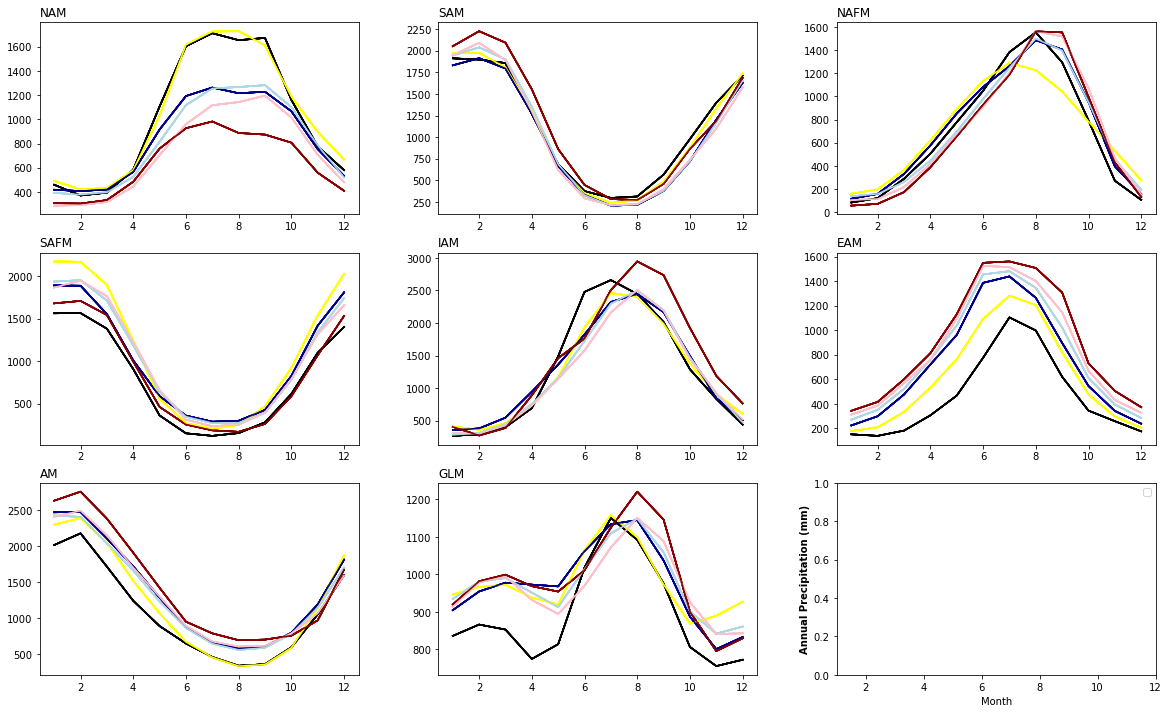

In [85]:
ncols = 3
nrows = 3
names = ["GPCP","PI","Mio280","Mio400","Mio560","Mio850"]
regions = ["NAM","SAM","NAFM","SAFM","IAM","EAM","AM","GLM"]
colors = ["black","yellow","darkblue","lightblue","pink","darkred"]
fig = plt.figure(figsize=(20, 12), dpi=100)
fig, axs = plt.subplots(3, 3, figsize=(20, 12), gridspec_kw=dict(wspace=0.25))
for j in range(0, len(regions)):
    for i in range(0, len(names)):
        axs[0,0].plot(NAMAP2.time,regionary2[:,0,i],linestyle='-',c=colors[i], label=names[i])
        axs[0,1].plot(NAMAP2.time,regionary2[:,1,i],linestyle='-',c=colors[i], label=names[i])
        axs[0,2].plot(NAMAP2.time,regionary2[:,2,i],linestyle='-',c=colors[i], label=names[i])
        axs[1,0].plot(NAMAP2.time,regionary2[:,3,i],linestyle='-',c=colors[i], label=names[i])
        axs[1,1].plot(NAMAP2.time,regionary2[:,4,i],linestyle='-',c=colors[i], label=names[i])
        axs[1,2].plot(NAMAP2.time,regionary2[:,5,i],linestyle='-',c=colors[i], label=names[i])
        axs[2,0].plot(NAMAP2.time,regionary2[:,6,i],linestyle='-',c=colors[i], label=names[i])
        axs[2,1].plot(NAMAP2.time,regionary2[:,7,i],linestyle='-',c=colors[i], label=names[i])
        axs[0,0].set_title(regions[0], loc='left',fontsize=12)
        axs[0,1].set_title(regions[1], loc='left',fontsize=12)
        axs[0,2].set_title(regions[2], loc='left',fontsize=12)
        axs[1,0].set_title(regions[3], loc='left',fontsize=12)
        axs[1,1].set_title(regions[4], loc='left',fontsize=12)
        axs[1,2].set_title(regions[5], loc='left',fontsize=12)
        axs[2,0].set_title(regions[6], loc='left',fontsize=12)
        axs[2,1].set_title(regions[7], loc='left',fontsize=12)

plt.xlabel("Month")
plt.xlim((1,12))
plt.ylabel("Annual Precipitation (mm)",weight='bold')
#plt.ylim(botlim[j],toplim[j])
        #ax.tick_params(axis='both', which='major', labelsize=12)
    
plt.legend()
plt.show()

In [1]:
import os

os.system('jupyter nbconvert --to html MioMIP-Hydro_Master_MonsoonAnalysis.ipynb')

[NbConvertApp] Converting notebook MioMIP-Hydro_Master_MonsoonAnalysis.ipynb to html
[NbConvertApp] Writing 1538883 bytes to MioMIP-Hydro_Master_MonsoonAnalysis.html


0